In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense, Dropout

In [2]:
# Define how many time steps will be used in observation and prediction
n_past = 24 # The last 24 hours of data
n_features = 2

# Set the universal font size for matplotlib
plt.rcParams['font.size'] = 11

In [3]:
# Define a function to split the series using a sliding window
def split_series(series, n_past=n_past):
    X, y = list(), list()
    for i in range(n_past * 2 - 1, len(series), n_past):
        X.append(series[i - n_past * 2 + 1: i - n_past + 1, :])
        y.append(float(series[i, 1]))
    return np.array(X, dtype=object), np.array(y, dtype=object)

In [4]:
# Process and split the data for a site given its filename
def prep_now_data(filename, startyear=2000):
    # Import the data for a single point
    data = pd.read_csv("Data/NOW-23 Great Lakes [2000-2020] 60min/" + filename, index_col=0)
    data.reset_index(inplace=True, drop=True)

    # Restrict the data to start before the month used for testing
    start_index = data[(data['Year'] == 2013) & (data['Month'] == 11) & (data["Day"] == 20)].index[0]
    end_index = data[(data['Year'] == 2013) & (data['Month'] == 12) & (data["Day"] == 20)].index[-1]
    start_year_index = data[data['Year'] == startyear].index[0]

    # Split the data into training and testing samples
    test_data = data.loc[start_index : end_index]
    data = data.loc[start_year_index : start_index - 1]
    
    # Designate which columns are used for training
    columns = [7, 8]
    
    # Normalize the testing and training data
    test_data.iloc[:, columns], test_norms = normalize(test_data.iloc[:, columns], axis=0, norm='max', return_norm=True)
    data.iloc[:, columns], train_norms = normalize(data.iloc[:, columns], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, columns]))
    X_test, y_test = split_series(np.array(test_data.iloc[:, columns]))
    
    return np.float32(X_train), np.float32(y_train), np.float32(X_test), np.float32(y_test), train_norms, test_norms

In [5]:
def prep_lidar_data(filename):
    # Import the data for a single point
    data = pd.read_csv("Data/lidar data/" + filename, index_col=0)
    data = data[data["Minute"] == "30"]
    
    # Restrict the data to start before the month used for testing
    start_index = data[(data['Year'] == 2013) & (data['Month'] == "11") & (data["Day"] == "20")].index[0]
    end_index = data[(data['Year'] == 2013) & (data['Month'] == "12") & (data["Day"] == "20")].index[-1]

    # Split the data into training and testing samples
    test_data = data.loc[start_index : end_index]
    data = data.loc[:start_index - 1]
    
    # Designate which columns are used for training
    columns = [5, 6]
    
    # Normalize the testing and training data
    test_data.iloc[:, columns], test_norms = normalize(test_data.iloc[:, columns], axis=0, norm='max', return_norm=True)
    data.iloc[:, columns], train_norms = normalize(data.iloc[:, columns], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, columns]))
    X_test, y_test = split_series(np.array(test_data.iloc[:, columns]))

    return np.float32(X_train), np.float32(y_train), np.float32(X_test), np.float32(y_test), train_norms, test_norms

In [6]:
# Define the model architecture
def define_model():
    # Lighter model used for additional training
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')

    return model

In [7]:
model = define_model()
model.summary()
model.input_shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               265216    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 306,433
Trainable params: 306,433
Non-trainable params: 0
_________________________________________________________________


(None, 24, 2)

In [227]:
X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data('141132.csv', startyear=2004)
X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms

model = define_model()
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8)
        
predictions = model.predict(X_test)
print(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))

Epoch 1/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1829 - val_loss: 0.1502
Epoch 2/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1243 - val_loss: 0.1616
Epoch 3/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1170 - val_loss: 0.1501
Epoch 4/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1157 - val_loss: 0.1322
Epoch 5/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1148 - val_loss: 0.1409
Epoch 6/50
451/451 [==============================] - 4s 10ms/step - loss: 0.1145 - val_loss: 0.1305
Epoch 7/50
451/451 [==============================] - 4s 10ms/step - loss: 0.1144 - val_loss: 0.1562
Epoch 8/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1143 - val_loss: 0.1440
Epoch 9/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1141 - val_loss: 0.1435
Epoch 10/50
451/451 [==============================] - 4s 9ms/step - loss: 0.1142 - val_loss: 0.13

<Axes: >

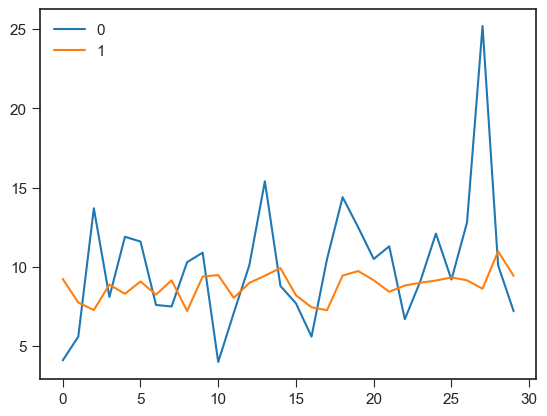

In [218]:
df = pd.concat([pd.Series(y_test) * test_norms[1], pd.Series(predictions[:, 0]) * train_norms[1]], axis=1)
df.plot()

In [108]:
# Train one model with data starting at different years
df = pd.DataFrame()
df['Years'] = list()
df['MAE'] = list()
df['STD'] = list()
for year in range(2000, 2014):
    print(f"{year}")
    
    mae = list()
    for i in range(10):
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
        real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data('141132.csv', startyear=year)
        X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms

        model = define_model()
        model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128, verbose=False)

        predictions = model.predict(X_test, verbose=False)
        mae.append(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))

    df.loc[len(df) + 1] = [int(year), np.average(mae), np.std(mae)]
df.to_csv('Data/Raw Experiment Data/starting year experiment.csv')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


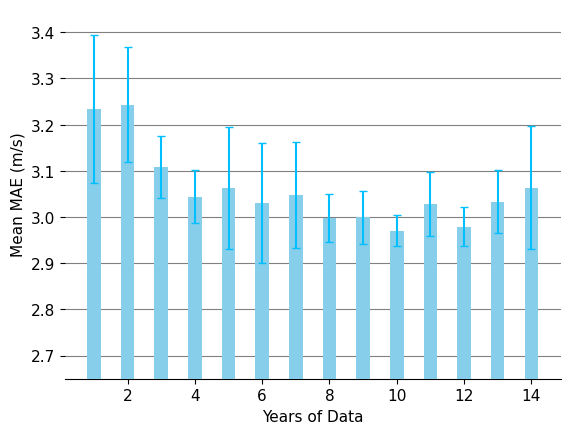

In [11]:
df = pd.read_csv('Data/Raw Experiment Data/starting year experiment.csv', index_col=0)
df['Years'] = [2014 - x for x in df['Years']]

# Display the data for use as a figure
ax = plt.axes()

# Remove the border from the graph
for direction in ['top', 'right', 'left']:
    ax.spines[direction].set_visible(False)
    
ax.set_facecolor("white")
plt.ylim(2.65, 3.45)
plt.grid(True, axis='y', color='grey')
plt.bar(df['Years'], df['MAE'], width=0.4, color="skyblue", zorder=3)
plt.errorbar(df['Years'], df['MAE'], yerr=df['STD'], capsize=3, linestyle="", color='deepskyblue', zorder=4)
plt.ylabel("Mean MAE (m/s)")
plt.xlabel("Years of Data")
plt.show()

In [198]:
# Train one model with a varying batch size
# df = pd.DataFrame()
# df['Batch Size'] = list()
# df['MAE'] = list()
# df['STD'] = list()
df = pd.read_csv('Data/Raw Experiment Data/batch size experiment.csv', index_col=0)
for batch_size in [64]:
    print(f"{batch_size}")
    
    mae = list()
    for i in range(10):
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
        real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data('141132.csv')
        X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms

        model = define_model()
        model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=batch_size, verbose=False)

        predictions = model.predict(X_test, verbose=False)
        mae.append(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))
        
    df.loc[9] = [int(batch_size), np.average(mae), np.std(mae)]
    # df[df['Batch Size'] == batch_size]  = [int(batch_size), np.average(mae), np.std(mae)] 
df.to_csv('Data/Raw Experiment Data/batch size experiment.csv')

64


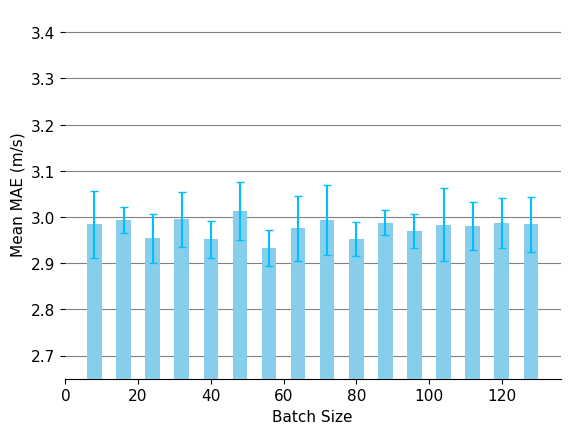

In [12]:
df = pd.read_csv(r'Data/Raw Experiment Data/batch size experiment.csv', index_col=0)
# Display the data for use as a figure
ax = plt.axes()

# Remove the border from the graph
for direction in ['top', 'right', 'left']:
    ax.spines[direction].set_visible(False)
    
ax.set_facecolor("white")
plt.ylim(2.65, 3.45)
plt.grid(True, axis='y', color='grey')
plt.bar(df['Batch Size'], df['MAE'], width=4, color="skyblue", zorder=3)
plt.errorbar(df['Batch Size'], df['MAE'], yerr=df['STD'], capsize=3, linestyle="", color='deepskyblue', zorder=4)
plt.ylabel("Mean MAE (m/s)")
plt.xlabel("Batch Size")
plt.show()

In [74]:
# Train one model with a varying number of epochs
df = pd.DataFrame()
df['Epochs'] = list()
df['MAE'] = list()
df['STD'] = list()
df = pd.read_csv(r'Data/Raw Experiment Data/epoch experiment.csv', index_col=0)
for epoch in range(50, 550, 50):
    print(f"{epoch}")
    
    mae = list()
    for i in range(10):
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
        real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data('141132.csv')
        X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms

        model = define_model()
        model.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),batch_size=128, verbose=False)

        predictions = model.predict(X_test, verbose=False)
        mae.append(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))
        
    df.loc[len(df)+1] = [int(epoch), np.average(mae), np.std(mae)]
df.to_csv('Data/Raw Experiment Data/epoch experiment.csv')

50
100
150
200
250
300
350
400
450
500


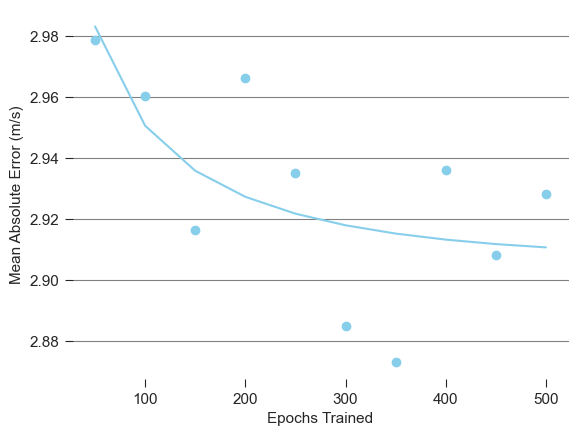

In [77]:
df = pd.read_csv(r'Data/Raw Experiment Data/epoch experiment.csv', index_col=0)
# Display the data for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
plt.xlabel('Epochs Trained')
plt.ylabel('Mean Absolute Error (m/s)')
# plt.ylim(y_lim)
plt.scatter(df['Epochs'], df['MAE'], color='skyblue')
plt.grid(True, axis='y', color='grey')

# Plot the logarithmic line of best fit
def plot_log_fit(x, y, deg):
    coeffs = np.polyfit(np.log(x), y, deg)

    ylist = list()
    for n in np.log(x):
        yvalue = np.sum([coeffs[i]*n**(len(coeffs)-1-i) for i in range(len(coeffs))])
        ylist.append(yvalue)
    plt.plot(x, ylist, color='skyblue')
    
plot_log_fit(df['Epochs'], df['MAE'], 2)

# Remove the border from the graph
for direction in ['top', 'right', 'bottom', 'left']:
    ax.spines[direction].set_visible(False)

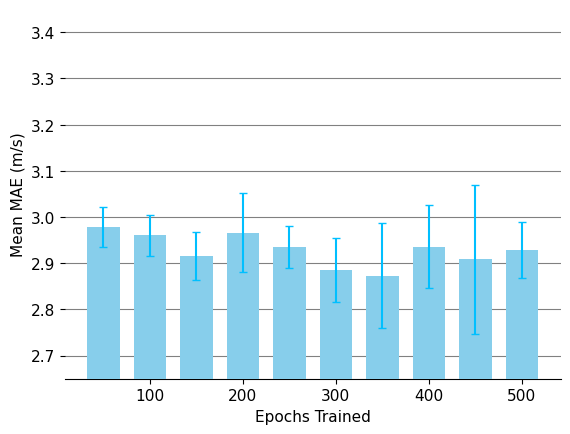

In [14]:
df = pd.read_csv(r'Data/Raw Experiment Data/epoch experiment.csv')

# Display the data for use as a figure
ax = plt.axes()

# Remove the border from the graph
for direction in ['top', 'right', 'left']:
    ax.spines[direction].set_visible(False)
    
ax.set_facecolor("white")
plt.ylim(2.65, 3.45)
plt.grid(True, axis='y', color='grey')
plt.bar(df['Epochs'], df['MAE'], width=35, color="skyblue", zorder=3)
plt.errorbar(df['Epochs'], df['MAE'], yerr=df['STD'], capsize=3, linestyle="", color='deepskyblue', zorder=4)
plt.ylabel("Mean MAE (m/s)")
plt.xlabel("Epochs Trained")
plt.show()

In [96]:
# Persistence model comparison

X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
predictions = [x[-1] for x in X_test[:, :, -1]]
print(mean_absolute_error(y_test * test_norms[1], np.float32(predictions) * test_norms[1]))

4.0233335


In [10]:
# Generate statistics for paired t-test
df = pd.DataFrame()
df['Real Model MAE'], df['Synthetic Model MAE'] = list(), list()
# df = pd.read_csv("Data/Raw Experiment Data/Comparison Statistics", index_col=0)
for i in range(30):
    print(f"Iteration {i + 1} of 30")
    # Train and test the real data model
    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
    real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms
    model = define_model()
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8, verbose=False)

    predictions = model.predict(X_test, verbose=False)
    real_MAE = mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1])

    # Train and test the synthetic data model

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data("141132.csv", startyear=2004)
    X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms
    model = define_model()
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8, verbose=False)

    predictions = model.predict(X_test, verbose=False)
    synthetic_MAE = mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1])

    df.loc[len(df)] = [real_MAE, synthetic_MAE]
    
# df.to_csv("Data/Raw Experiment Data/Comparison Statistics.csv")

Iteration 1 of 30


FileNotFoundError: [Errno 2] No such file or directory: 'Data/NOW-23 Great Lakes [2000-2020] 60min/141132.csv'

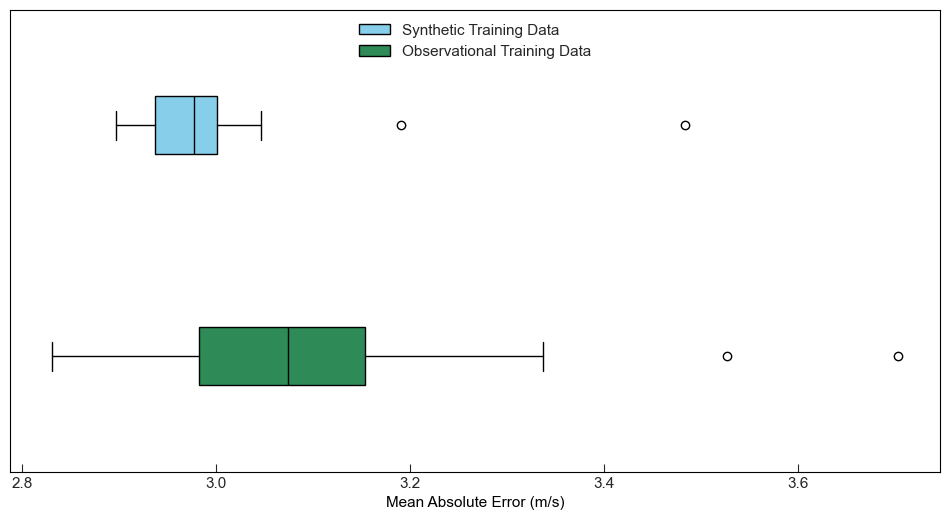

In [8]:
# Load the data
# df = pd.read_csv("Data/Raw Experiment Data/Comparison Statistics.csv", index_col=0)

# Generate a box plot to describe the MAE distribution for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
fig = plt.gcf()
frame = plt.gca()
fig.set_size_inches(12, 6)
frame.axes.get_yaxis().set_visible(False)

plt.style.use('seaborn-v0_8-ticks')
bplot = plt.boxplot([(df['Real Model MAE']), df['Synthetic Model MAE']], vert=False, patch_artist=True, medianprops=dict(color='black'),
            boxprops=dict(facecolor='white'), widths=0.25)

for patch, color in zip(bplot['boxes'], ['seagreen', 'skyblue']):
    patch.set_facecolor(color)

plt.xlabel("Mean Absolute Error (m/s)")
plt.tick_params(axis='x', which='major', reset=True, direction='in', top=False)
ax.legend([bplot['boxes'][1], bplot['boxes'][0]], ['Synthetic Training Data', 'Observational Training Data'], loc='upper center')
plt.show()

In [230]:
real = df['Real Model MAE']
synthetic = df['Synthetic Model MAE']
avg_diff = np.average(real) - np.average(synthetic)
std_real, std_synthetic = np.std(real), np.std(synthetic)
n_real, n_synthetic = len(real), len(synthetic)

print(f"t statistic: {avg_diff / np.sqrt((std_real**2 / n_real) + (std_synthetic**2 / n_synthetic))}")
print(f"average synthetic MAE: {np.average(synthetic)}, STD: {std_synthetic}")
print(f"average real MAE: {np.average(real)} STD: {std_real}")

t statistic: 2.9329139052339444
average synthetic MAE: 2.994718646666667, STD: 0.10502157613057024
average real MAE: 3.10523938 STD: 0.17768095490798558


In [125]:
df = pd.DataFrame(columns=['Model Type', 'Epochs', 'Batch Size', 'Mean MAE', 'STD MAE'])
for model_type in ['Synthetic LSTM', 'Observational LSTM']:
    for pair in [[50, 128], [50, 8], [500, 128]]:
        epochs = pair[0]
        batch_size = pair[1]
        print(f'{model_type} with {epochs} epochs and batch size {batch_size}')
        
        iterations = 30
        mae_list = list()
        for i in range(iterations):
            print(f"Iteration {i + 1} of 30")
            X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
            real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

            if model_type == 'Observational LSTM':
                model = define_model()
                model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=False)
            elif model_type == 'Synthetic LSTM':
                X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data("141132.csv", startyear=2004)
                X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms
                model = define_model()
                model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=False)

            predictions = model.predict(X_test, verbose=False)
            mae_list.append(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))
            
        df.loc[len(df)] = [model_type, epochs, batch_size, np.average(mae_list), np.std(mae_list)]
        df.to_csv('Data/Raw Experiment Data/Optimization Statistics.csv')

Synthetic LSTM with 50 epochs and batch size 128
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30
Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30
Synthetic LSTM with 50 epochs and batch size 8
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 

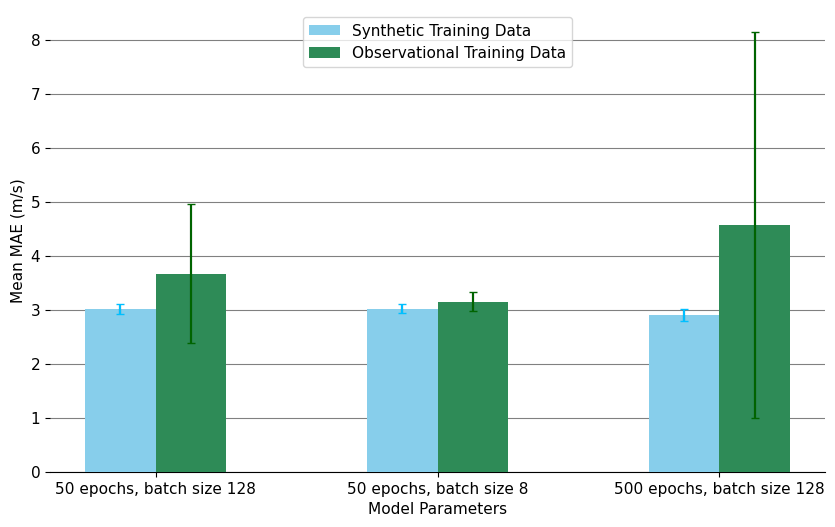

In [16]:
# Load in the data and combine parameters
df = pd.read_csv('Data/Raw Experiment Data/Optimization Statistics.csv', index_col=0)
param_list = list()
for i in range(len(df)):
    epochs = df.loc[i, 'Epochs']
    batch_size = df.loc[i, 'Batch Size']
    param_list.append(f'{epochs} epochs, batch size {batch_size}')
df['Parameters'] = param_list

# Construct a grouped bar chart to display the data
width = 0.25
x = np.arange(len(df)//2)

df_synthetic = df[df['Model Type'] == 'Synthetic LSTM']
df_observational = df[df['Model Type'] == 'Observational LSTM']

ax = plt.axes()
# Remove the border from the graph
for direction in ['top', 'right', 'left']:
    ax.spines[direction].set_visible(False)

plt.bar(x-width/2, df_synthetic['Mean MAE'], yerr=df_synthetic['STD MAE'], color='skyblue', width=width, zorder=3)
plt.bar(x+width/2, df_observational['Mean MAE'], yerr=df_observational['STD MAE'], color='seagreen', width=width, zorder=3)
plt.errorbar(x-width/2, df_synthetic['Mean MAE'], yerr=df_synthetic['STD MAE'], color='deepskyblue', capsize=3, linestyle="", zorder=4)
plt.errorbar(x+width/2, df_observational['Mean MAE'], yerr=df_observational['STD MAE'], color='darkgreen', capsize=3, linestyle="", zorder=4)

# Add axis labels and display the graph
plt.ylabel('Mean MAE (m/s)')
plt.xlabel("Model Parameters")
plt.xticks(x, df_synthetic['Parameters'])
plt.legend(['Synthetic Training Data', 'Observational Training Data'], loc='upper center')

fig = plt.gcf()
plt.grid(True, axis='y', color='grey')
fig.set_size_inches(10, 6)
plt.show()

In [157]:
df = pd.read_csv('Data/Raw Experiment Data/Optimization Statistics.csv', index_col=0)
for model_type in ['Observational LSTM']:
    for pair in [[50, 8]]:
        epochs = pair[0]
        batch_size = pair[1]
        print(f'{model_type} with {epochs} epochs and batch size {batch_size}')
        
        iterations = 30
        mae_list = list()
        for i in range(iterations):
            print(f"Iteration {i + 1} of 30")
            X_train, y_train, X_test, y_test, train_norms, test_norms = prep_lidar_data("buoy2013compiled.csv")
            real_X_test, real_y_test, real_test_norms = X_test, y_test, test_norms

            if model_type == 'Observational LSTM':
                model = define_model()
                model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=False)
            elif model_type == 'Synthetic LSTM':
                X_train, y_train, X_test, y_test, train_norms, test_norms = prep_now_data("141132.csv", startyear=2004)
                X_test, y_test, test_norms = real_X_test, real_y_test, real_test_norms
                model = define_model()
                model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=False)

            predictions = model.predict(X_test, verbose=False)
            mae_list.append(mean_absolute_error(y_test * test_norms[1], predictions * train_norms[1]))
            
        df.loc[1] = [model_type, epochs, batch_size, np.average(mae_list), np.std(mae_list)]
        df.to_csv('Data/Raw Experiment Data/Optimization Statistics.csv')

Synthetic LSTM with 50 epochs and batch size 8
Iteration 1 of 30
Iteration 2 of 30
Iteration 3 of 30
Iteration 4 of 30
Iteration 5 of 30
Iteration 6 of 30
Iteration 7 of 30
Iteration 8 of 30
Iteration 9 of 30
Iteration 10 of 30
Iteration 11 of 30
Iteration 12 of 30
Iteration 13 of 30
Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30
Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
Iteration 30 of 30
